In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_5_timing_park_'

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
from skimage import measure
from IPython.display import clear_output

from mpl_toolkits.mplot3d import Axes3D

import dill

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
# print(mpl.rcParams.keys())

In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 1.5 # -> 23ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 10
# kappa defines the divisive influence of the inhibitory input
kappa_r = 0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [117]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.minimum(np.maximum(q_pc-0.01,0),1)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
#     excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) # * 1/( gaba_exc+1.0) 
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
#     inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(gaba_inh+1.0)       
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
#     excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
#     inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q



# Input

In [165]:
gbc_offsets = np.array(np.arange(-110,120,2))
#gbc_input_intensities = np.array([1.0,2.5,5.0,7.5,10.0])
# sbc_input_intensities = np.array([0.5])
# gbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])
# gbc_input_intensities = np.linspace(0,1,11)

default_int = 0.35

gbc_input_intensities = np.linspace(0.0,default_int+0.05,21)
# sbc_input_intensities = np.linspace(1,0,11)
sbc_input_intensities = np.ones((21))*default_int

# store the solutions
q_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(gbc_offsets),len(gbc_input_intensities),len(t),freq_bands))


sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)

sigma_neighbor = 1.0

# gauss_mask_spectral = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma_neighbor)
gauss_mask_spectral = gauss(np.linspace(-5,+5,freq_bands),0,sigma_neighbor)
gauss_mask_temporal = gauss(np.linspace(-50,50,100),0,2)
gauss_mask_temporal /= gauss_mask_temporal.sum()

stimuli_presentation_times_sbc = np.zeros((len(gbc_offsets),len(gbc_input_intensities),10,2))
stimuli_presentation_times_gbc = np.zeros((len(gbc_offsets),len(gbc_input_intensities),10,2))

# fig = plt.figure()
# ax = fig.add_subplot(111)

for l in range(len(gbc_offsets)):
    for k in range(len(gbc_input_intensities)):
        
        
        


        ############################################################
        #                       Inputs                             #
        ############################################################

        
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))
        
        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 650
        gbc_input_duration = 30
        gbc_input_offset = gbc_offsets[l]
        gbc_center_frequencyBand = 2
        gbc_input_strength = gbc_input_intensities[k]
        td_gbc = int((gbc_input_strength*100)*1.00)
        gbc_input_onset -= td_gbc 
        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
#         gbc_gauss_mask = gauss(np.arange(gbc_input_duration),gbc_input_duration/2,sigma)
        # build a plateau at the end to let the neurons go to a steady state

        
#         for i in range(3):
#             offet = i*150
        start = gbc_input_onset+gbc_input_offset
        stop = gbc_input_onset+gbc_input_offset+gbc_input_duration
        s_gbc_all[start:stop,gbc_center_frequencyBand] =  gbc_input_strength
        stimuli_presentation_times_gbc[l,k,:,0] = start
        stimuli_presentation_times_gbc[l,k,:,1] = stop

        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask_spectral,axis=1,mode='reflect')

        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 650
        sbc_input_duration = 30
        sbc_input_offset =  0
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]
                td_sbc = int((sbc_input_strength*100)*1.00)
        sbc_input_onset -=td_sbc
        start = sbc_input_onset+sbc_input_offset
        stop = sbc_input_onset+sbc_input_offset+sbc_input_duration
        s_sbc_all[start:stop,sbc_center_frequencyBand] =  sbc_input_strength
        stimuli_presentation_times_sbc[l,k,:,0] = start
        stimuli_presentation_times_sbc[l,k,:,1] = stop
        

        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask_spectral,axis=1,mode='reflect')

        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask_temporal,axis=0,mode='reflect')
        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask_temporal,axis=0,mode='reflect')


         ############################################################
        #                      Simulation                          #
        ############################################################
        for i in range(0, len(t)-20):

         
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            r_all[l,k,i+1,:] = r_all[l,k,i,:] +  dt * ode_r_bpc(r_all[l,k,i,:],s_sbc_all[i],ee_kernel,g_q_out(q_all[l,k,i,:]),ei_kernel)       
            q_all[l,k,i+1,:] = q_all[l,k,i,:] +  dt * ode_q_pc(q_all[l,k,i,:],s_gbc_all[i+20],ie_kernel,q_all[l,k,i,:],ii_kernel)
    
    clear_output(wait=True)
    print(l)
    
# plt.show()

114


In [145]:
import dill
# dill.dump_session('figure_5_timing_TID_incl_test')
# dill.load_session('timing_exp_timing_intensity_trading')

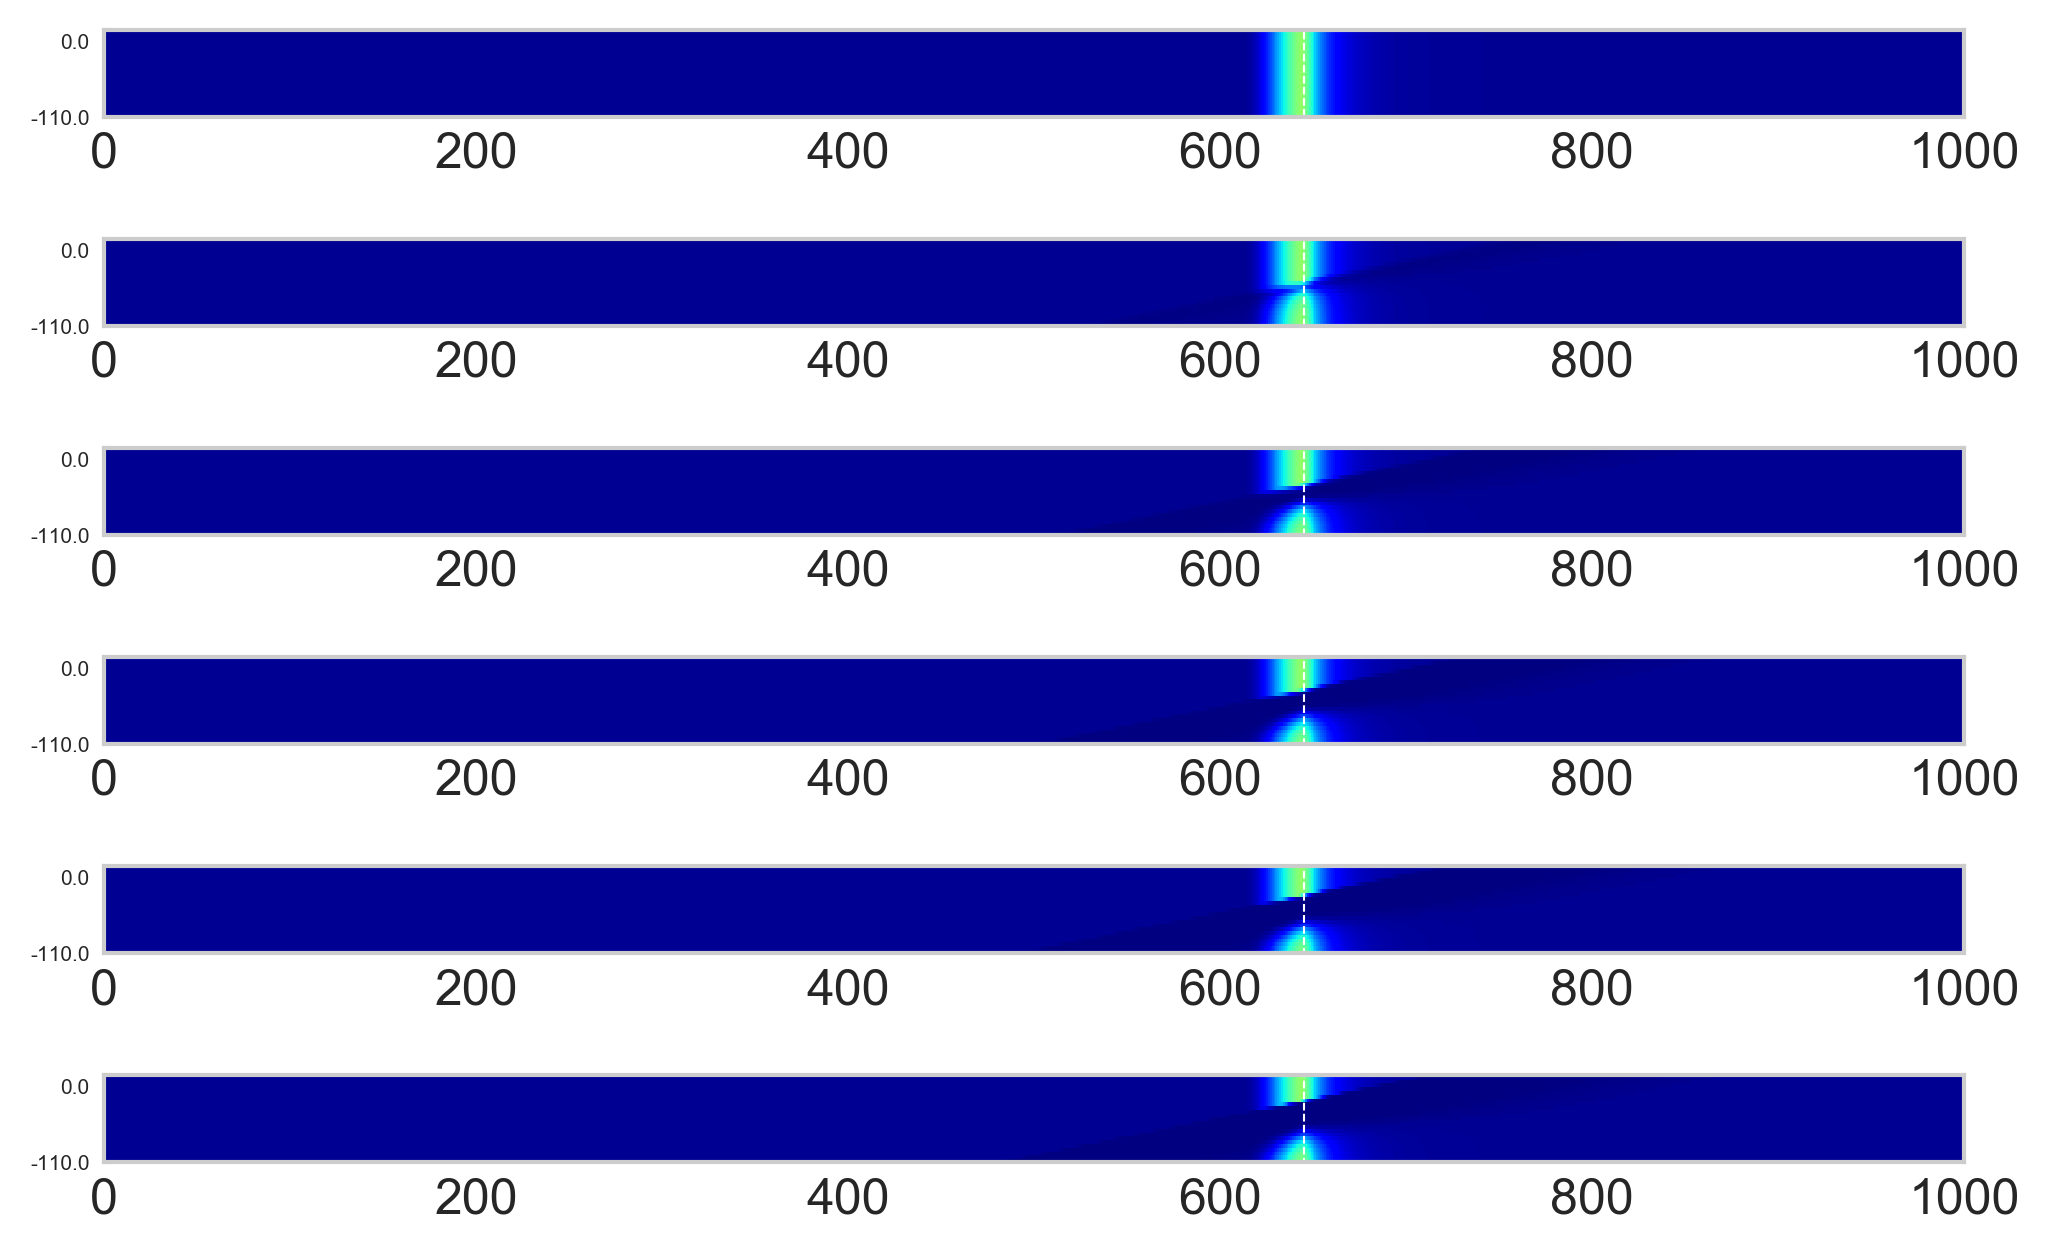

In [152]:
# # ############################################################
# # #                       Plotting                           #
# # ############################################################


probing_time =665
probing_time =645

fig = plt.figure()
stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
#plt.suptitle(stri,fontsize=16)
#r = r_all[:,:,500:900,3]
r = r_all[:,:,:,sbc_center_frequencyBand]


for i in range(0,r.shape[1],2):
    ax1 = plt.subplot2grid((r.shape[1], 1), (i, 0), colspan=2)
    ax1.pcolormesh(g_r_out(r[:,i,:1000]),cmap='jet',vmin=0.0,vmax=1.0)
    
    ax1.axvline(x=probing_time, ymin=-100.0, ymax=100.0, color='white',linestyle='--',linewidth=0.5)    

#     tmp = gbc_offsets[::int((len(gbc_offsets)/len(ax1.get_yticks())))+5]
    ax1.set_yticklabels(np.linspace(gbc_offsets[0],gbc_offsets[-1],len(ax1.get_yticks())),fontsize=5)
#     ax1.set_xticklabels(ax1.get_xticks()/100)
#     plt.tight_layout()

plt.show()


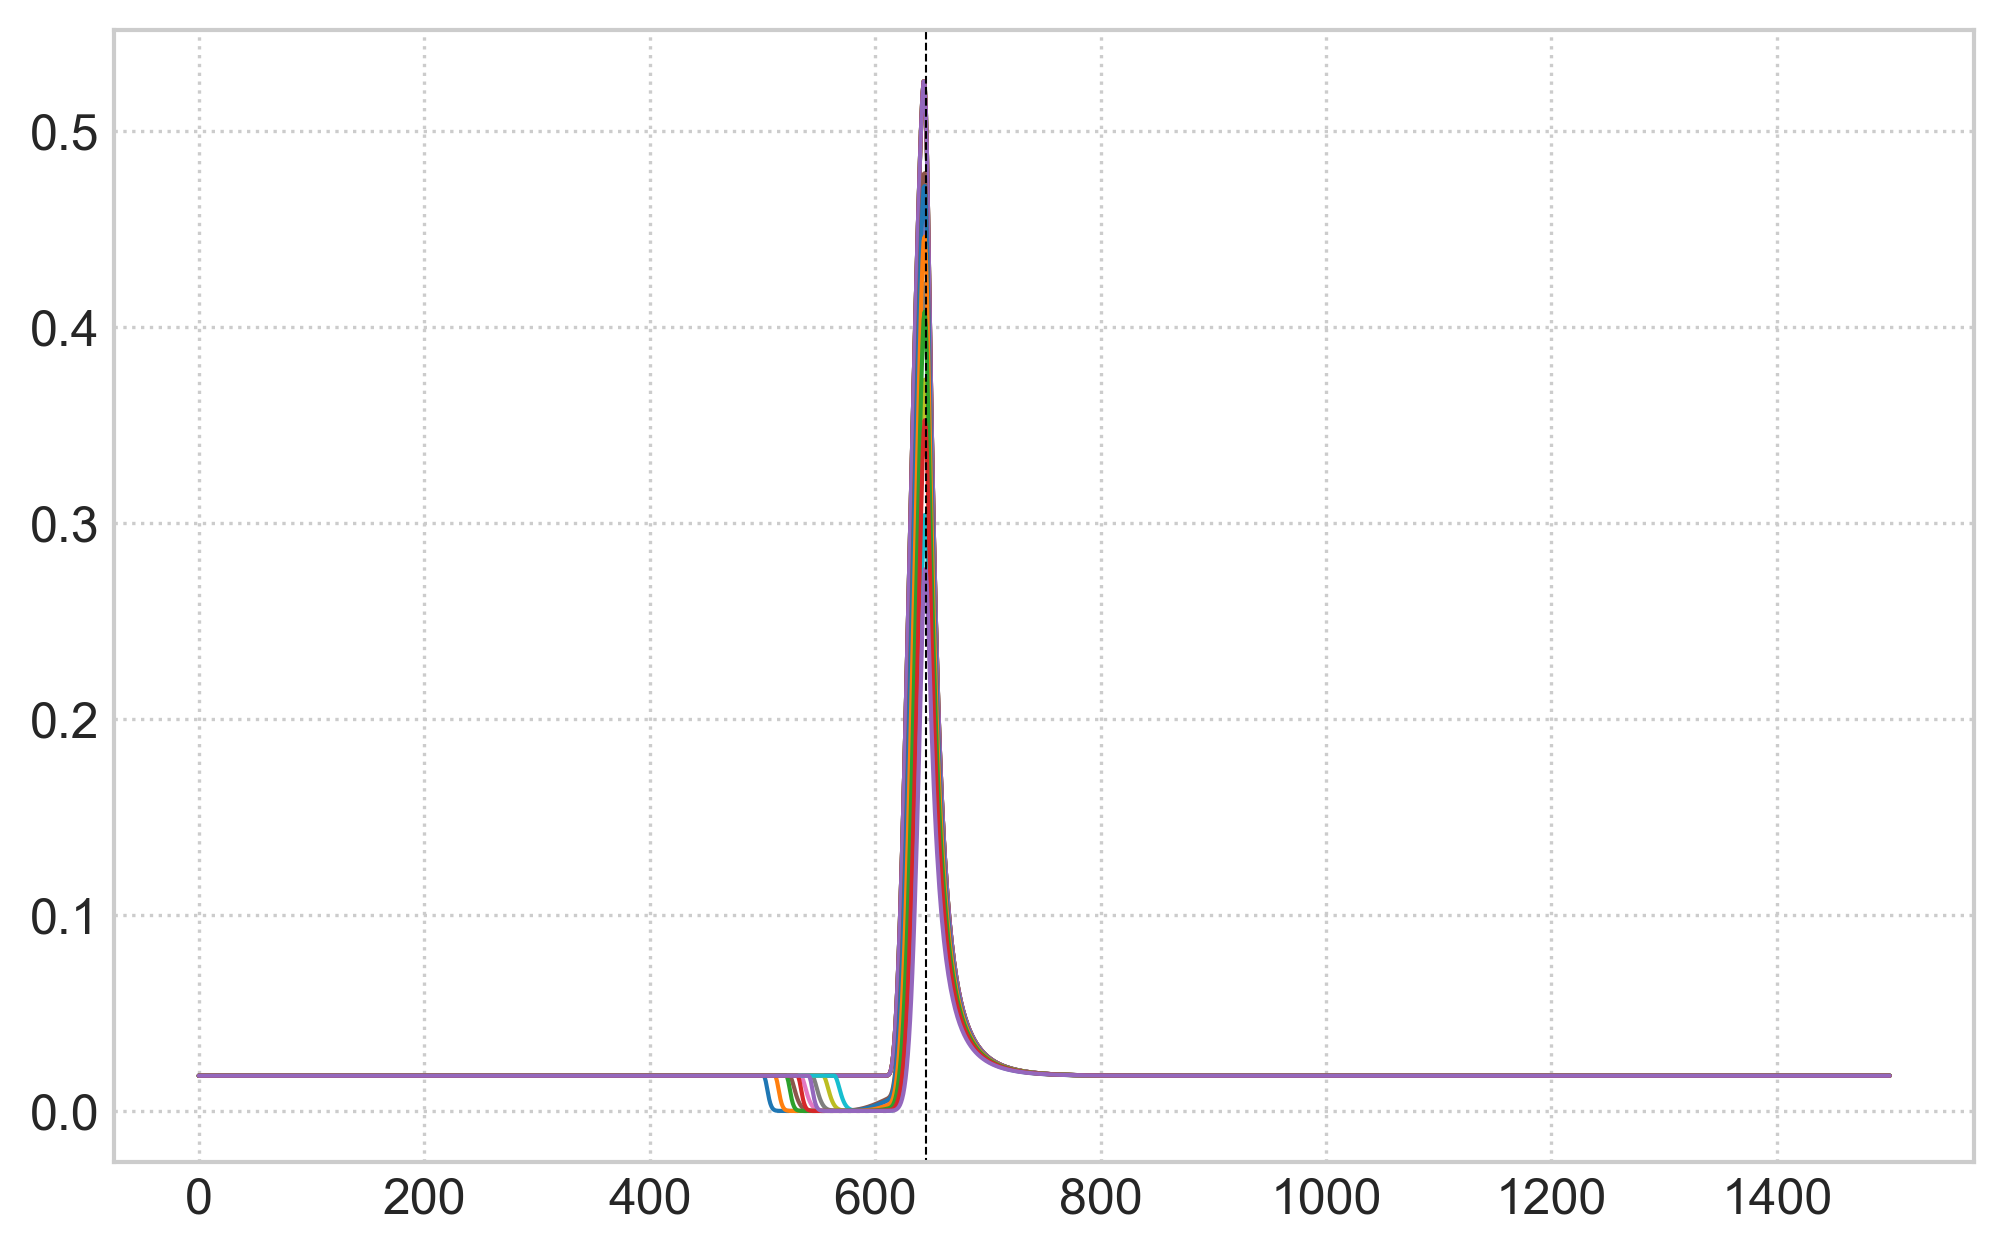

In [167]:
# probing_time =665
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# # print(gbc_offsets[6])
# for i in range(0,r.shape[1],10):
#     ax1.plot(g_r_out(r[:,i,:]).T)
# ax1.axvline(x=probing_time, ymin=0.0, ymax=1.0, color='black',linestyle='--',linewidth = 1)    


# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.plot(s_sbc_all[:,sbc_center_frequencyBand],linestyle=':')
# ax1.plot(s_gbc_all[:,sbc_center_frequencyBand],linewidth= 1)
# r = r_all[:,:,:,sbc_center_frequencyBand]
# q = q_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(0,r.shape[1],5):
    ax1.plot((r[2:7,i,:].T),linewidth= 1)
#     ax1.plot((q[:-5,i,:].T),linewidth= 1)

ax1.axvline(x=probing_time, ymin=-100.0, ymax=100.0, color='black',linestyle='--',linewidth=0.5)    

plt.show()

In [168]:
# # probing_time = 640
# # fig = plt.figure()
# # ax1 = fig.add_subplot(111)
# # # print(gbc_offsets[6])
# # for i in range(0,r.shape[1],10):
# #     ax1.plot(g_r_out(r[:,i,:]).T)
# # ax1.axvline(x=probing_time, ymin=0.0, ymax=1.0, color='black',linestyle='--',linewidth = 1)    


# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.plot(s_sbc_all[:,sbc_center_frequencyBand],linestyle=':')
# ax1.plot(s_gbc_all[:,sbc_center_frequencyBand],linewidth= 1)


# ax1.axvline(x=probing_time, ymin=-100.0, ymax=100.0, color='black',linestyle='--',linewidth=0.5)    

# plt.show()

In [178]:
# flip the offsets to match ITD in literature
gbc_offsets = -gbc_offsets

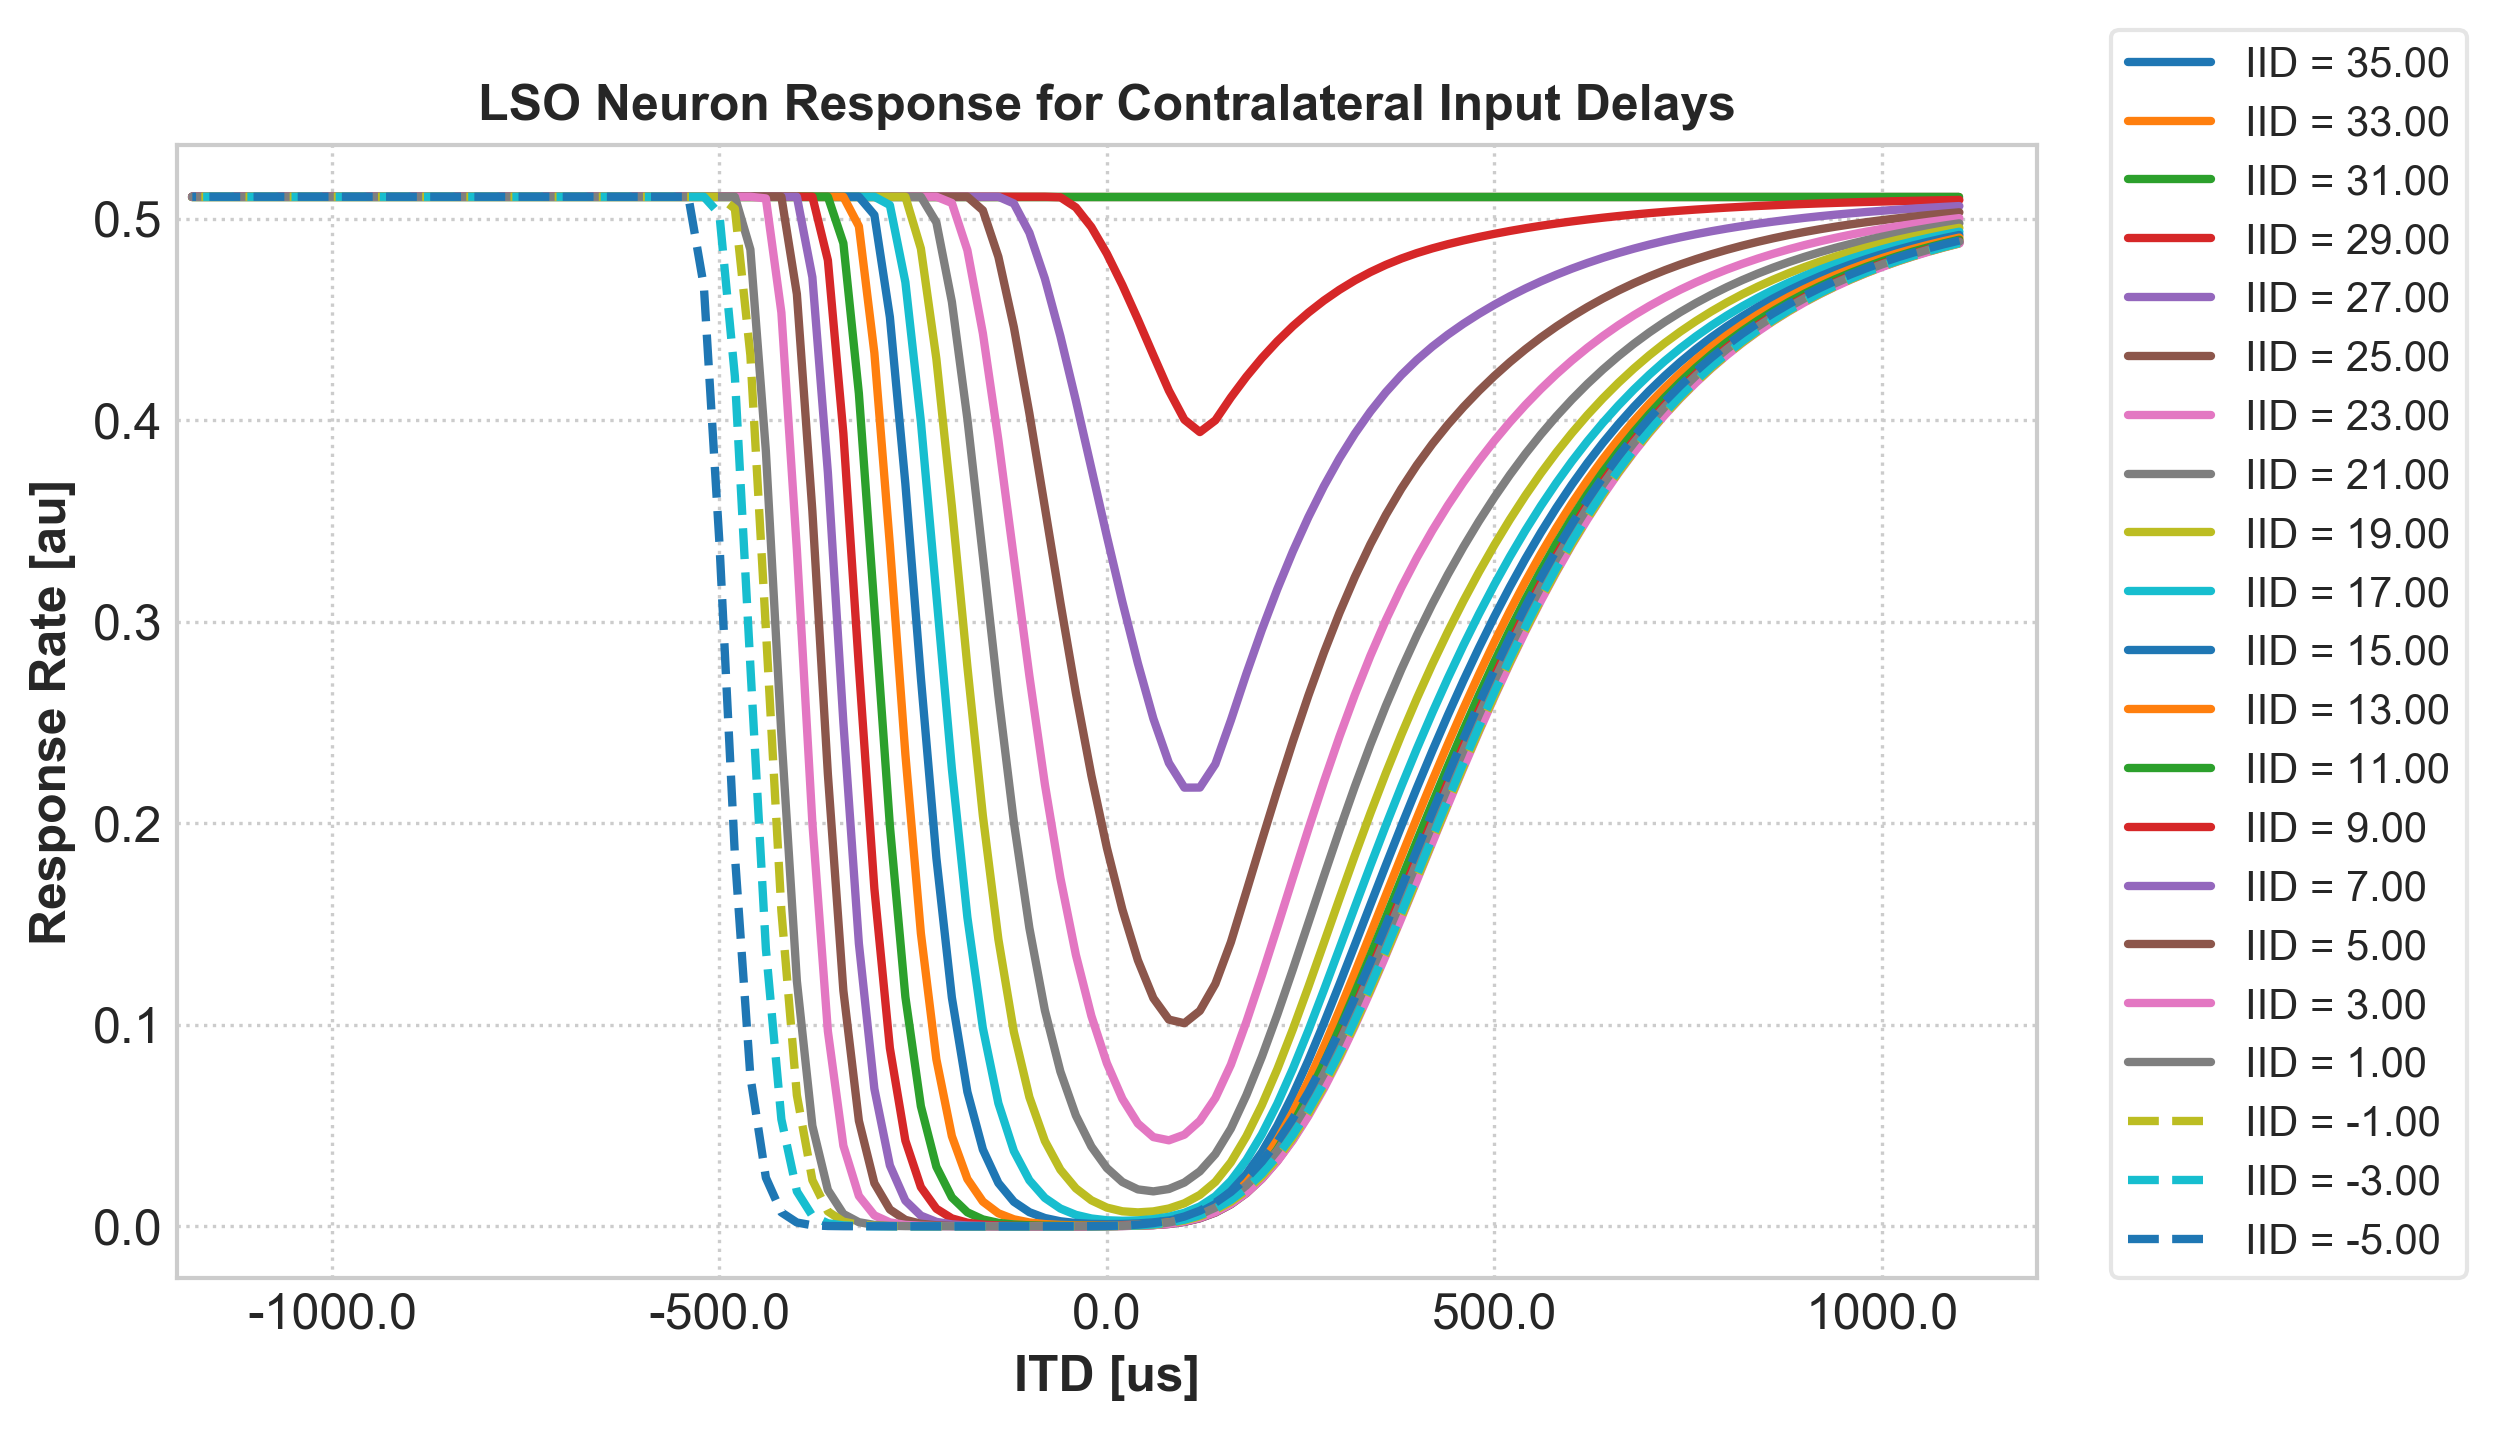

In [180]:
fig = plt.figure()


r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]

ax1 = fig.add_subplot(111)
for i in range(r.shape[1]):
      
    level_diff = sbc_input_intensities[i] - gbc_input_intensities[i]
    if level_diff <= 0:
        line_style = '--'
    else:
        line_style = '-'

    maxi = r[:,i,probing_time]
    
#     ax1.plot(gbc_offsets[:]+(-td_gbc)+100,maxi,linestyle = line_style,label='Input Intensity Difference = {0:.2f}'.format(level_diff))
    ax1.plot(gbc_offsets[:],maxi,linestyle = line_style,label='IID = {0:.2f}'.format(level_diff*100))

    
plt.title('LSO Neuron Response for Contralateral Input Delays')
plt.xlabel('ITD [us]')
plt.ylabel('Response Rate [au]')
ax1.set_xlim([-120,120])
# ax1.invert_xaxis()
ax1.set_xticklabels(ax1.get_xticks()*10)
lgd = plt.legend(loc=(1.04,0))

plt.savefig(figure_name + 'timing_curves.svg', bbox_inches='tight')
plt.savefig(figure_name + 'timing_curves.pdf',bbox_inches='tight')


plt.show()


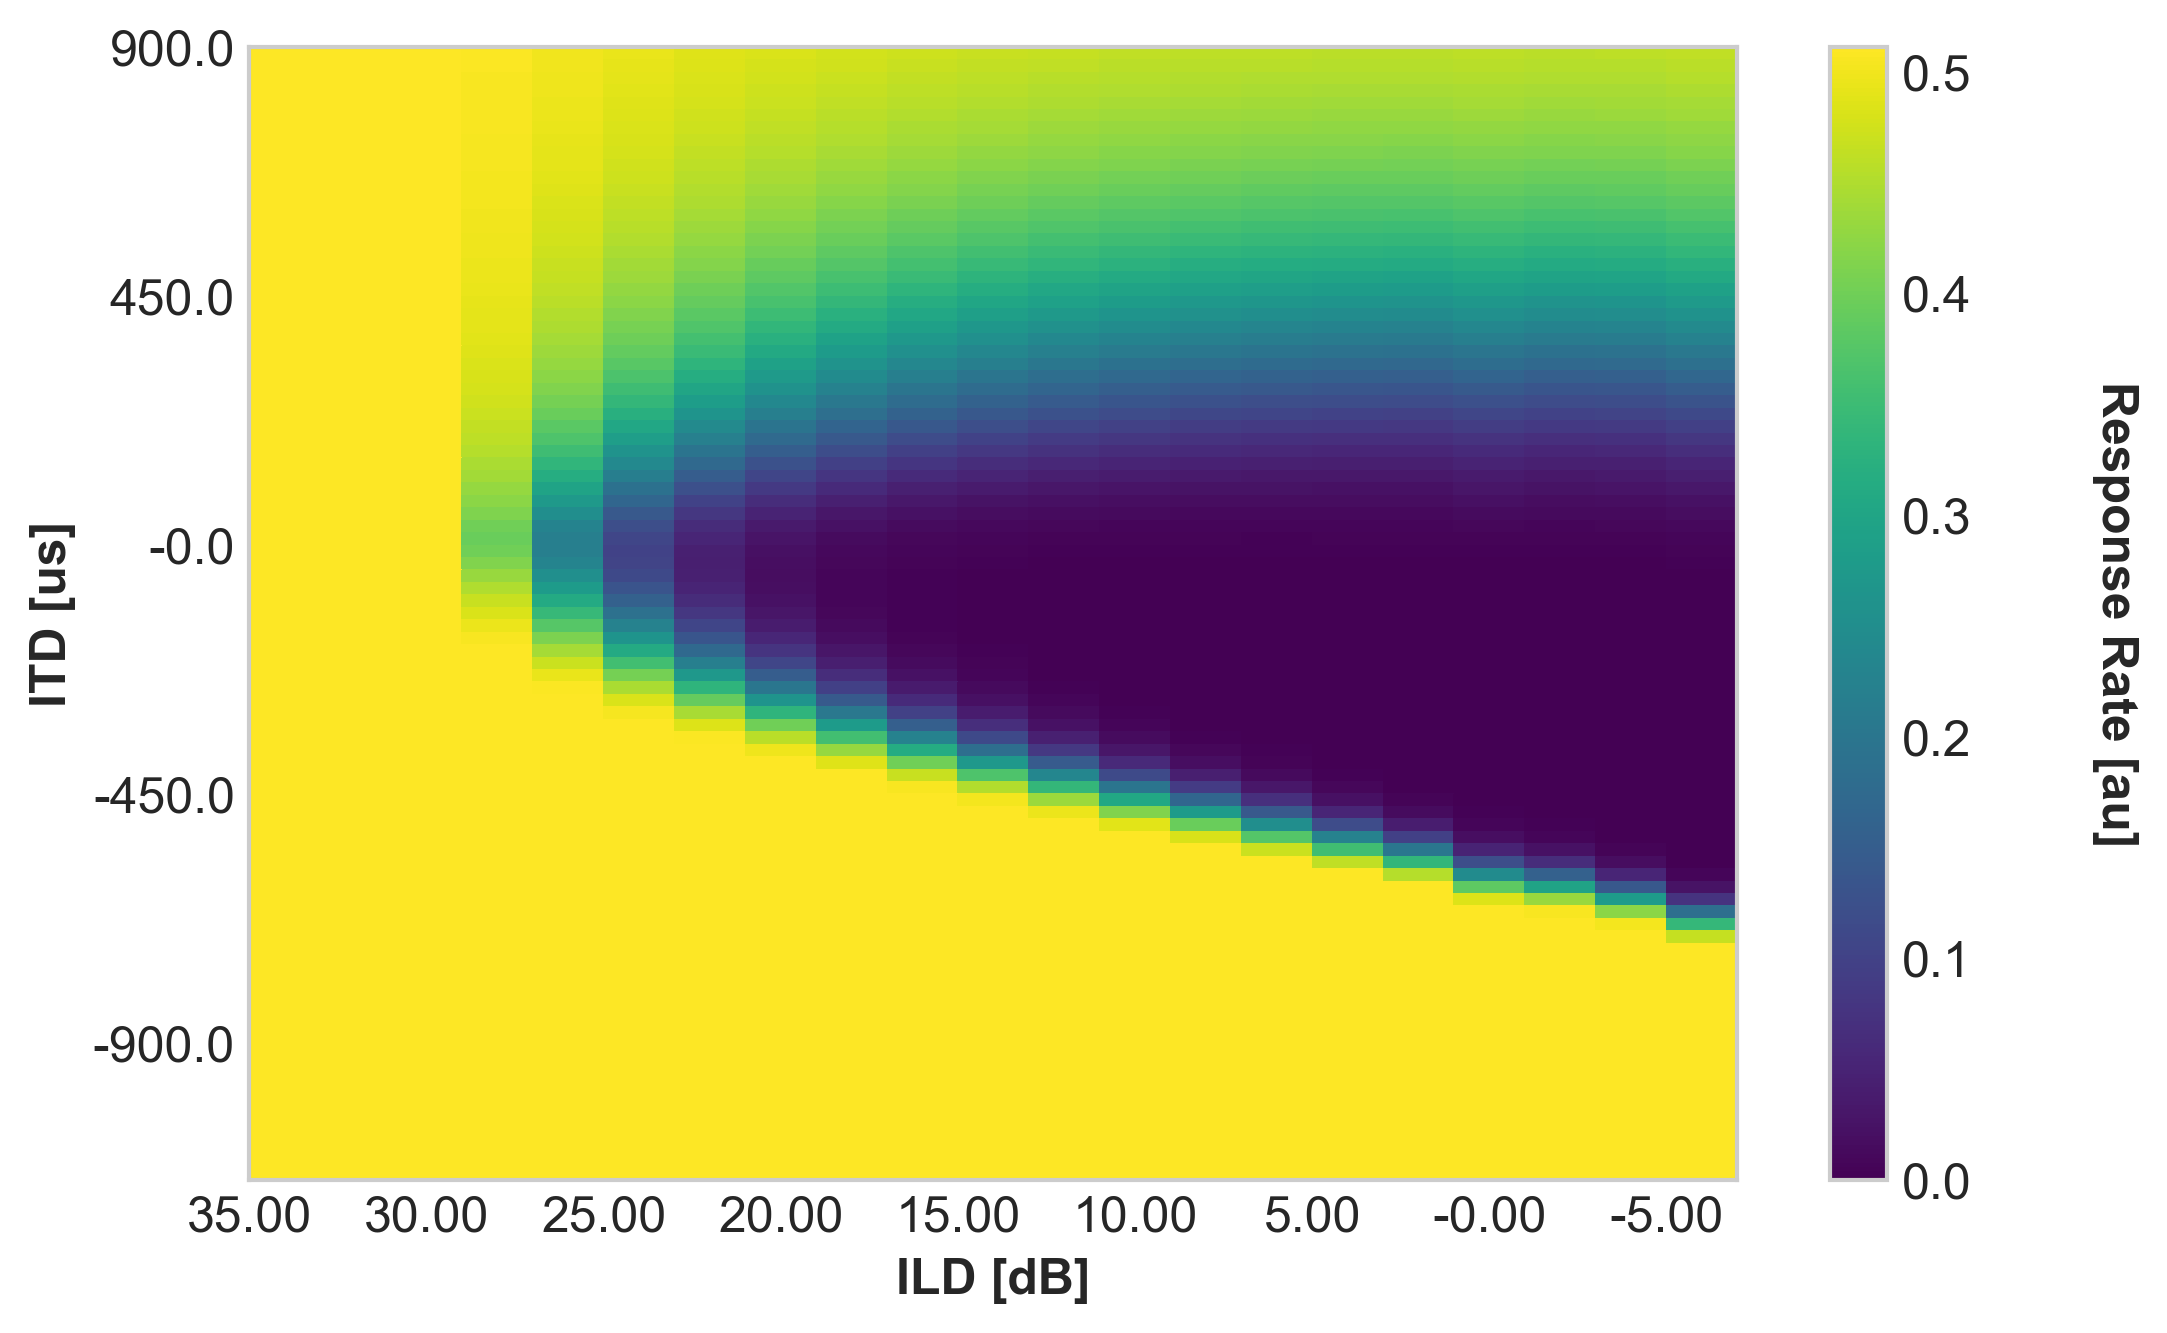

In [5]:
import matplotlib.ticker as ticker

# probing_time = 668
fig = plt.figure()

used_delay_ind = np.arange(10,len(gbc_offsets)-14)
# r = g_r_out(np.squeeze(r_all[:,:,860:1060,sbc_center_frequencyBand]).max(-1))
r = g_r_out(np.squeeze(r_all[:,:,probing_time,sbc_center_frequencyBand]))
q = q_all[:,:,:,sbc_center_frequencyBand]

tmp = r[used_delay_ind,:]

mirrord_rf = tmp

ax1 = fig.add_subplot(111)

c = ax1.pcolormesh(mirrord_rf,cmap="viridis",linewidth=0,rasterized=True,vmin=0.)

# add a horizontal lone 
# ax1.hlines(10,0,82,color='C0',linestyle='-')

plt.xlabel('ILD [dB]')
plt.ylabel('ITD [us]')
# plt.title('LSO Receptive Field')
cbar = plt.colorbar(c)
cbar.set_label('Response Rate [au]', rotation=270, labelpad=40,)



# ax1.set_xlim(([0,20]))

start_int = (gbc_input_intensities[0]-sbc_input_intensities[0])
stop_int = (gbc_input_intensities[-1]-sbc_input_intensities[0])
ild_ticks = np.linspace(start_int,stop_int,int(len(ax1.get_xticks()))-1)
ax1.set_xticklabels(['{0:.2f}'.format(-i*100) for i in ild_ticks])


itd_ticks = gbc_offsets[used_delay_ind]
itd_ticks = np.linspace(np.min(itd_ticks),np.max(itd_ticks),len(ax1.get_yticks())-1)
ax1.set_yticklabels(['{0:.1f}'.format(-i*10) for i in itd_ticks])
ax1.invert_yaxis()
# # set ticks a bit down
# for tick in ax1.get_xaxis().get_major_ticks():
#     tick.set_pad(20.)
#     tick.label1 = tick._get_text1()
    

plt.savefig(figure_name + 'receptive_field_2d.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'receptive_field_2d.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'receptive_field_2d.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')
# plt.tight_layout()
plt.show()


In [10]:
level_diff

array([ 0.35,  0.33,  0.31,  0.29,  0.27,  0.25,  0.23,  0.21,  0.19,
        0.17,  0.15,  0.13,  0.11,  0.09,  0.07,  0.05,  0.03,  0.01,
       -0.01, -0.03, -0.05])

0.19
0.15000000000000002
0.09000000000000002
0.050000000000000044


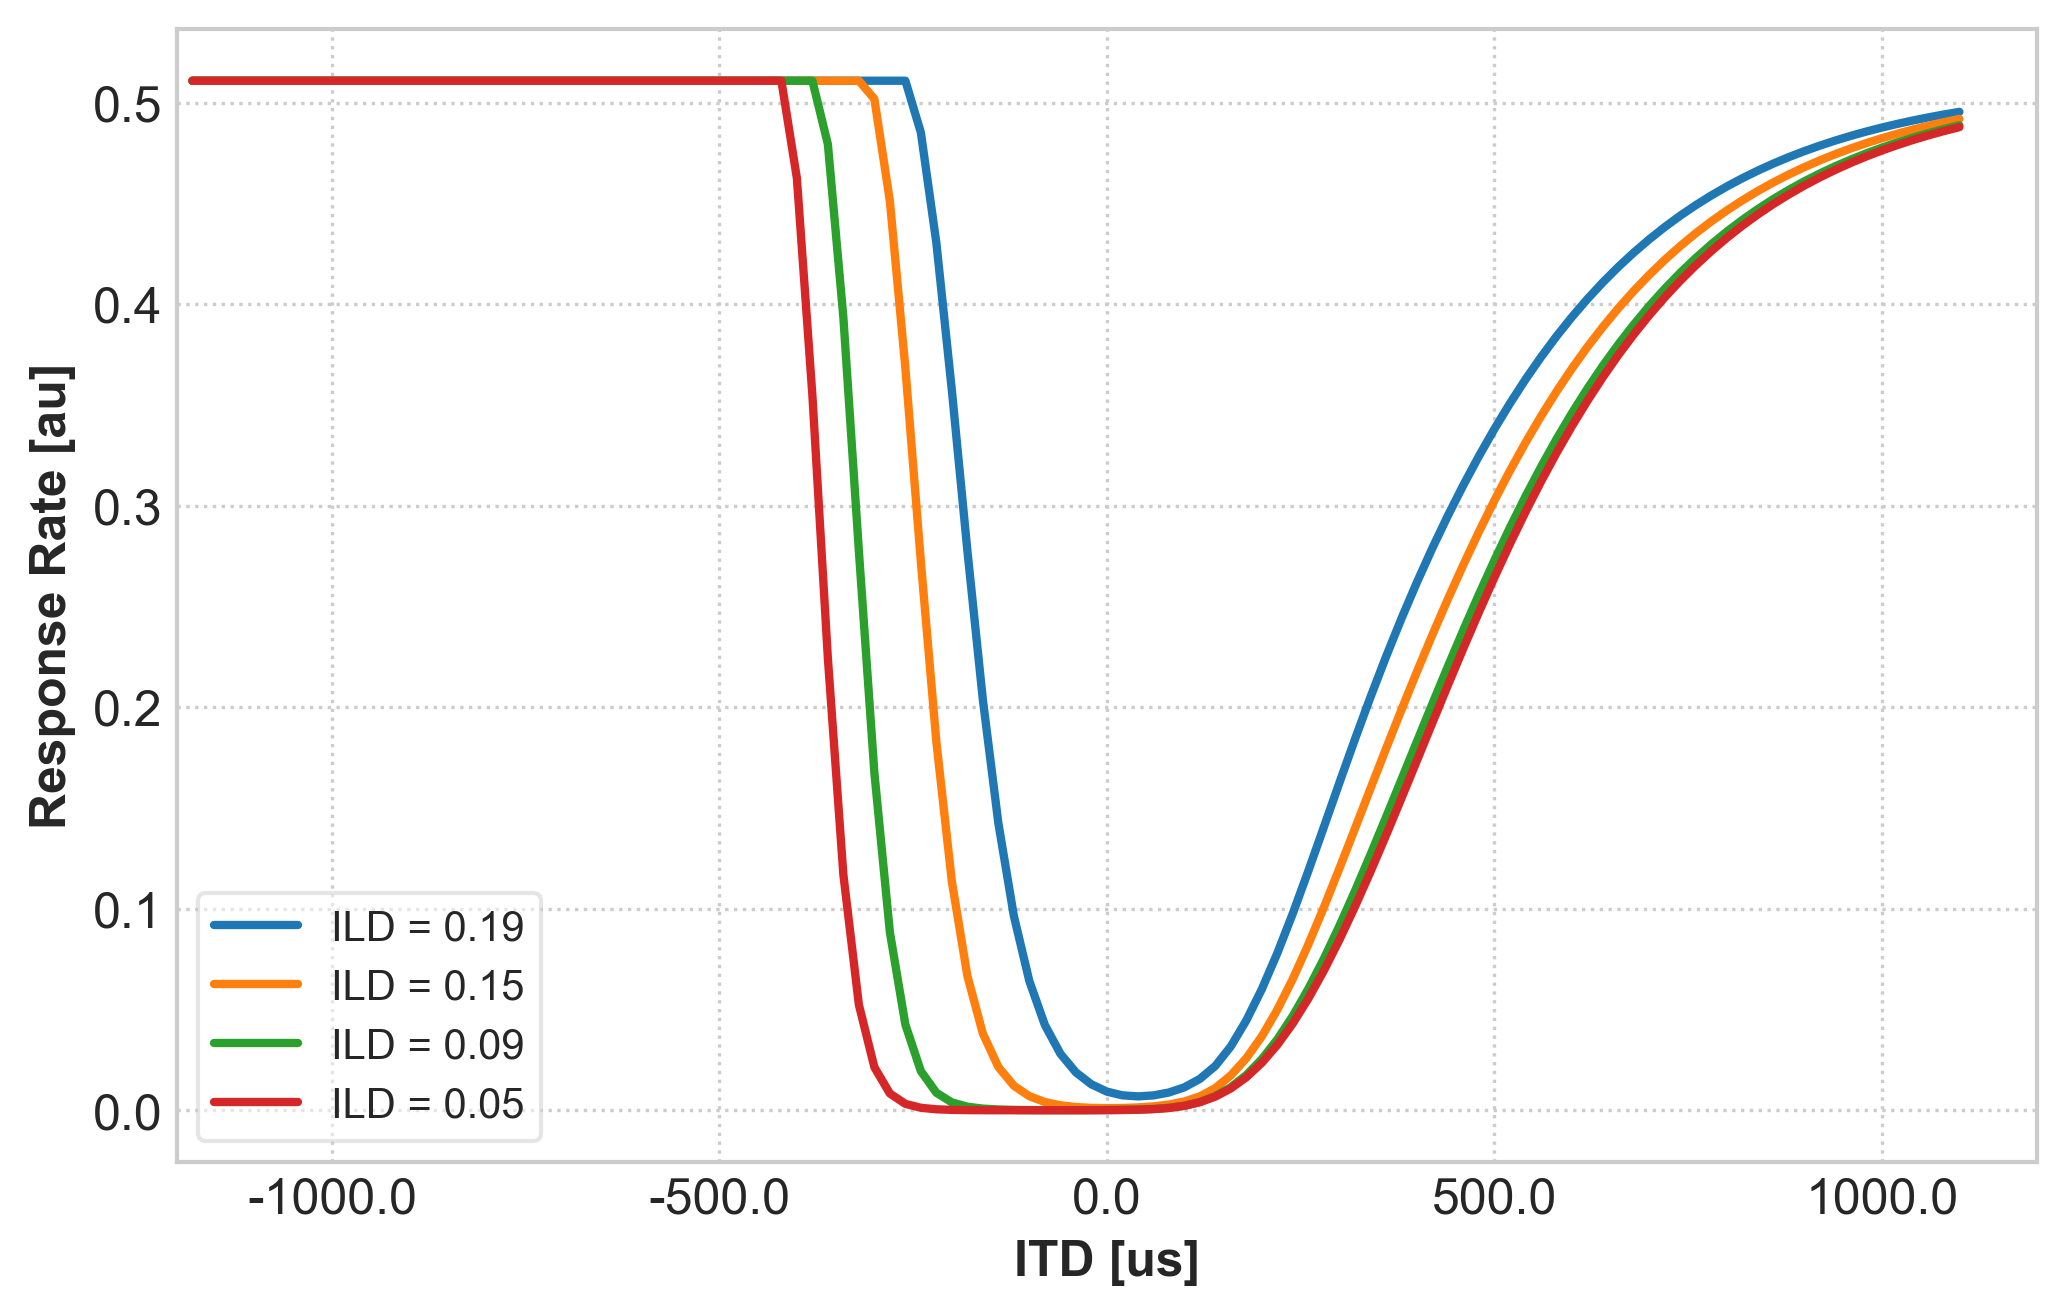

In [13]:
fig = plt.figure()


r = np.squeeze(g_r_out(r_all[:,:,probing_time,sbc_center_frequencyBand]))
q = q_all[:,:,:,sbc_center_frequencyBand]
level_diff = sbc_input_intensities - gbc_input_intensities

ax1 = fig.add_subplot(111)

plot_ild = 8
print(level_diff[plot_ild])
plot_handler = ax1.plot(gbc_offsets[:],r[:,plot_ild],label='ILD = {0:.2f}'.format(level_diff[plot_ild]))

plot_ild = 10
print(level_diff[plot_ild])
plot_handler = ax1.plot(gbc_offsets[:],r[:,plot_ild],label='ILD = {0:.2f}'.format(level_diff[plot_ild]))

plot_ild = 13
print(level_diff[plot_ild])
plot_handler = ax1.plot(gbc_offsets[:],r[:,plot_ild],label='ILD = {0:.2f}'.format(level_diff[plot_ild]))

plot_ild = 15
print(level_diff[plot_ild])
plot_handler = ax1.plot(gbc_offsets[:],r[:,plot_ild],label='ILD = {0:.2f}'.format(level_diff[plot_ild]))
# fill_handler_2 = ax1.fill_between(gbc_offsets[:], np.squeeze(r[:,8]),zero_ild_plot_values, facecolor='#9ecae1', alpha=0.7,label='positive ILD')
# fill_handler_1 = ax1.fill_between(gbc_offsets[:], zero_ild_plot_values, r[:,20], facecolor='#6baed6', alpha=0.7,label='negative ILD')

    
# plt.title('LSO Neuron Response for Ipsilateral Input Delays')
plt.xlabel('ITD [us]')
plt.ylabel('Response Rate [au]')

ax1.set_xlim([-120,120])
ax1.set_xticklabels(ax1.get_xticks()*10)


# ax1.set_ylim([0,1])

lgd = plt.legend()

# plt.savefig(figure_name + 'timing_curves_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'timing_curves_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
# plt.savefig(figure_name + 'timing_curves_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

a = sbc_input_intensities - gbc_input_intensities
# print(a[6],a[13])

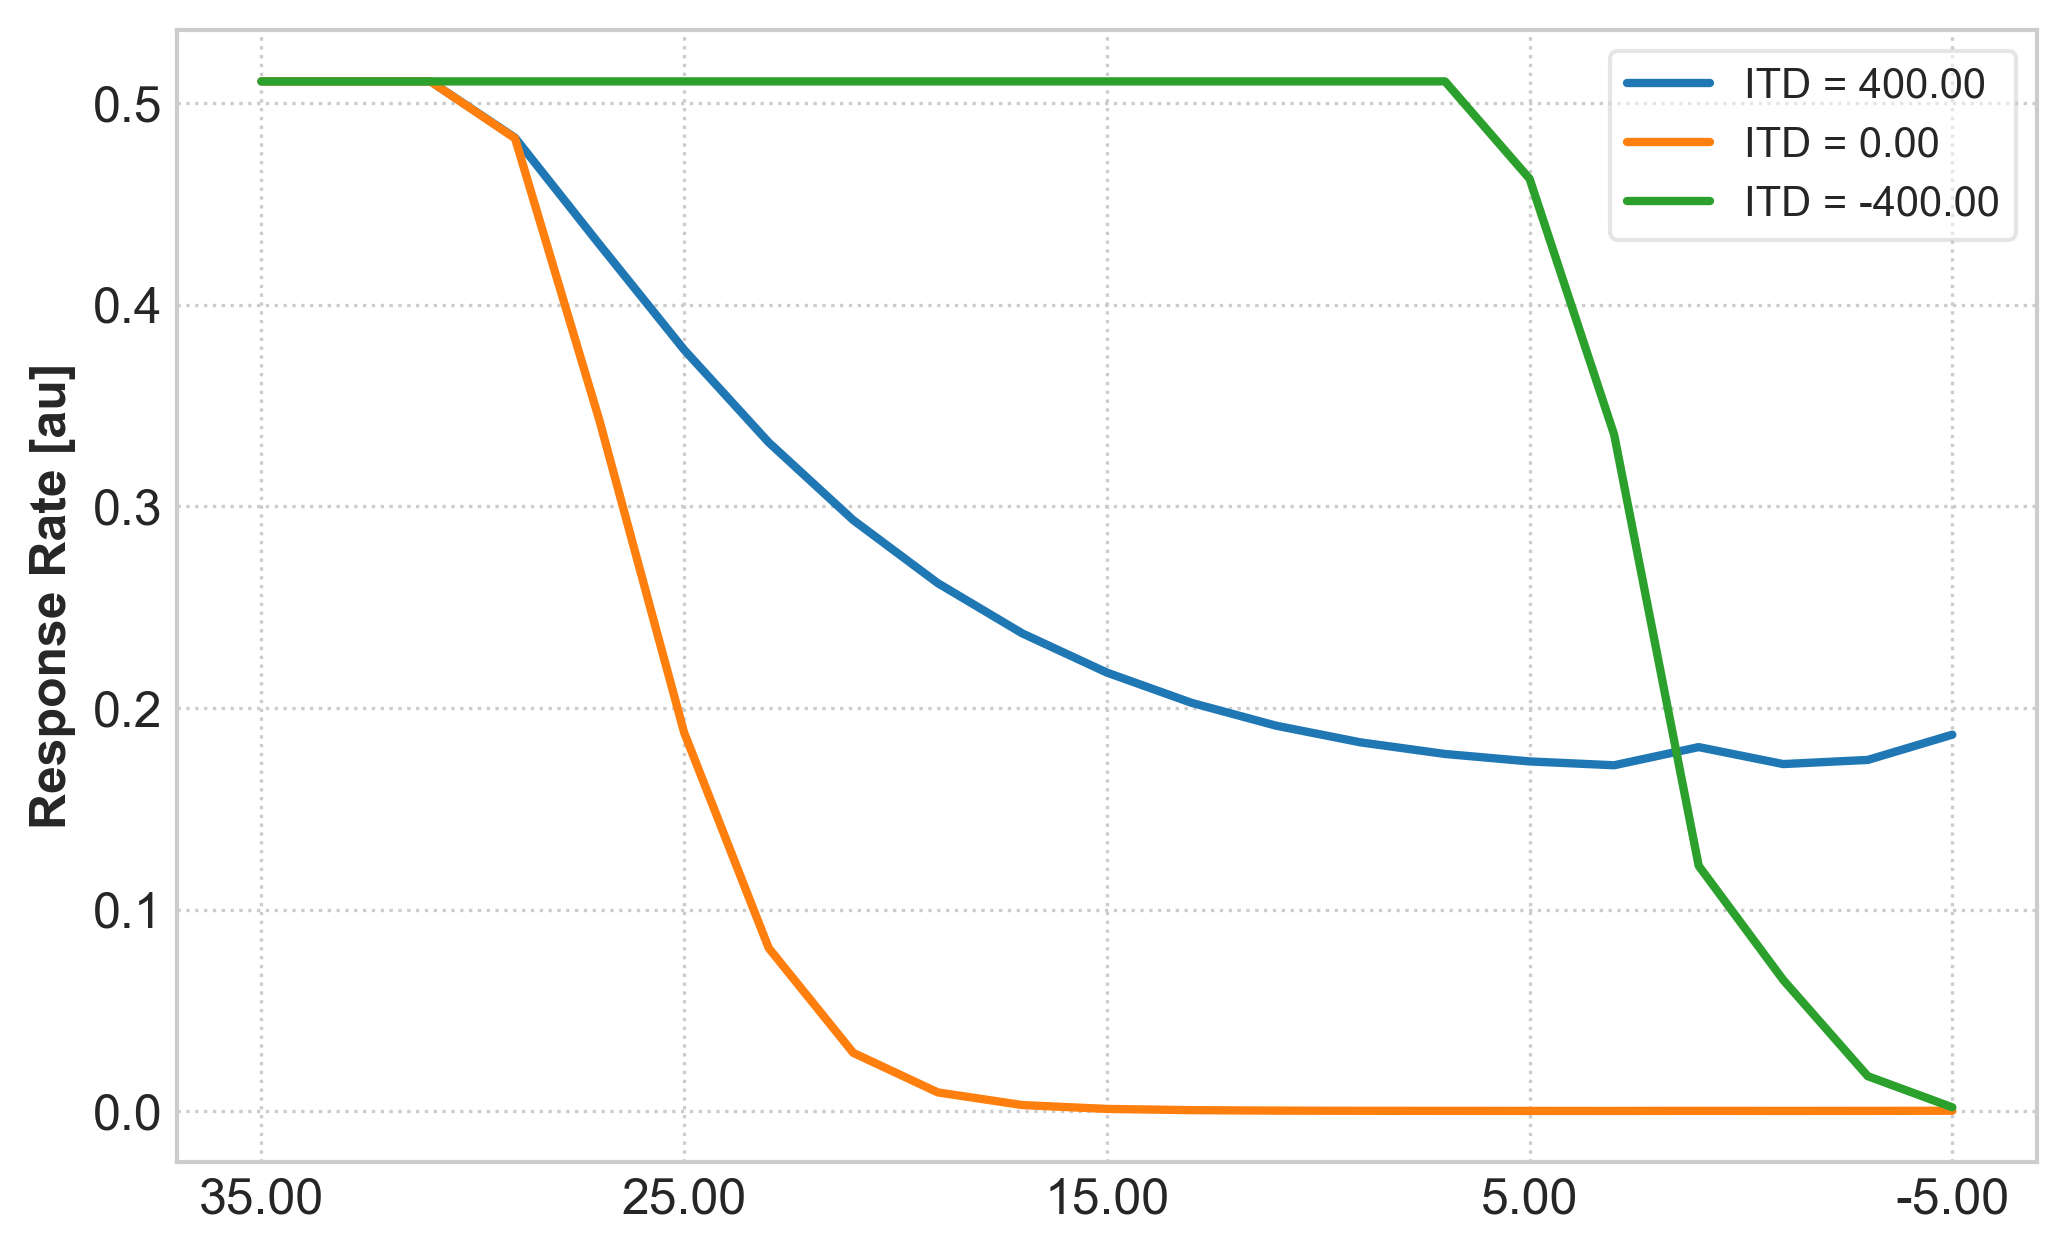

In [18]:
fig = plt.figure()

# probing_time = 1200
r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
ax1 = fig.add_subplot(111)
diff = sbc_input_intensities-gbc_input_intensities

zero_bound = 35
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[zero_bound,:,probing_time],label='ITD = {0:.2f}'.format(gbc_offsets[zero_bound]*10))

zero_bound = 55
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[zero_bound,:,probing_time],label='ITD = {0:.2f}'.format(gbc_offsets[zero_bound]*10))

zero_bound = 75
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[zero_bound,:,probing_time],label='ITD = {0:.2f}'.format(gbc_offsets[zero_bound]*10))




diff = sbc_input_intensities-gbc_input_intensities
ax1.set_xticks(diff[::5])
ax1.set_xticklabels(["{0:2.2f}".format(i*100) for i in ax1.get_xticks()])


plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
lgd = plt.legend()

# plt.savefig(figure_name + 'ild_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'ild_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
# plt.savefig(figure_name + 'ild_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

0.010000000000000009


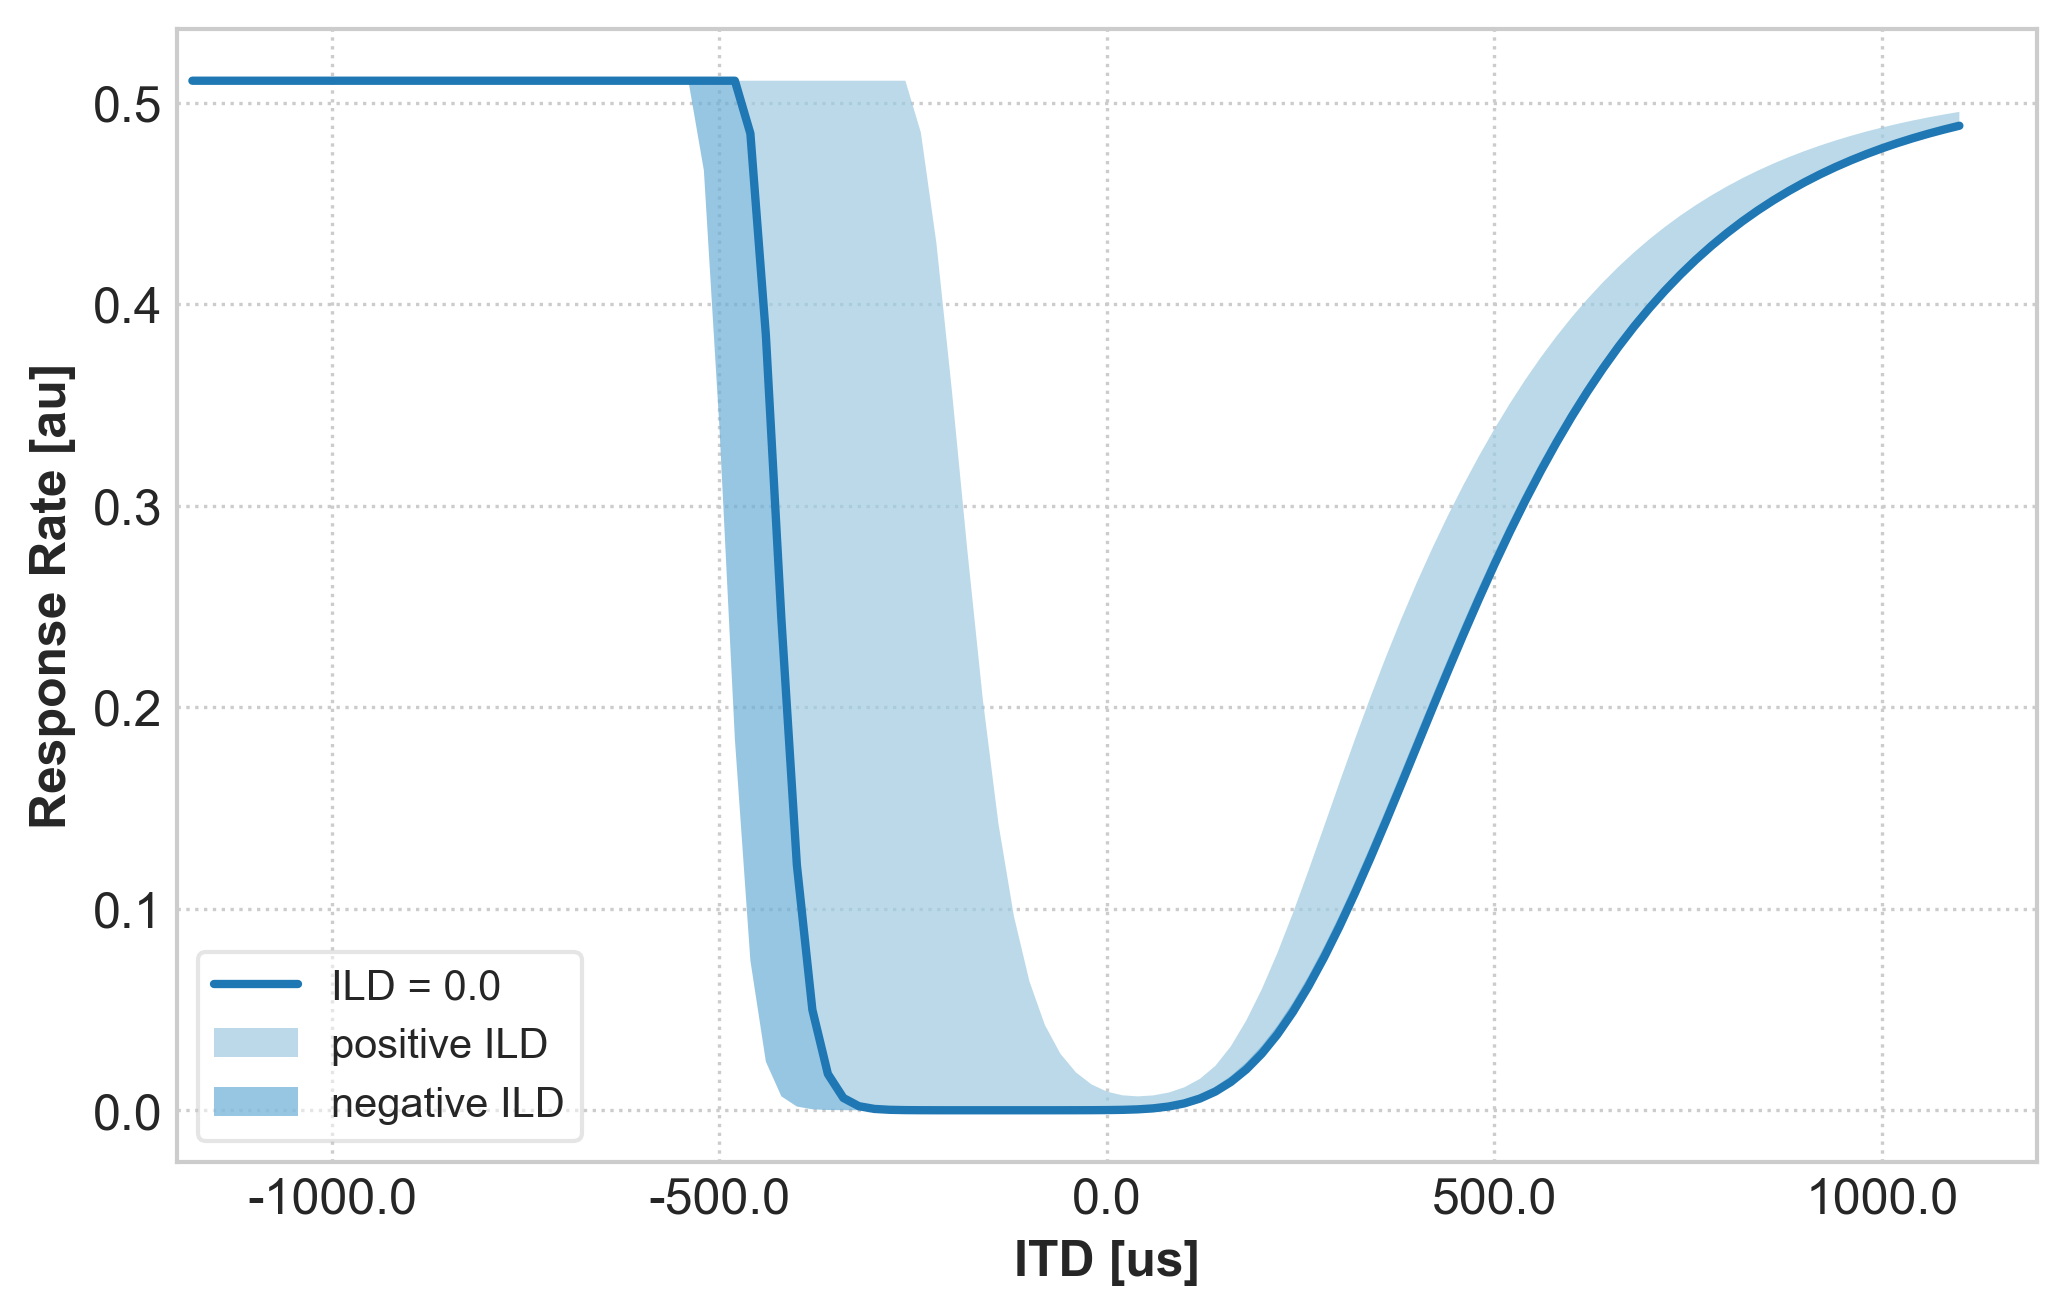

In [233]:
fig = plt.figure()


r = np.squeeze(g_r_out(r_all[:,:,probing_time,sbc_center_frequencyBand]))
q = q_all[:,:,:,sbc_center_frequencyBand]
level_diff = sbc_input_intensities - gbc_input_intensities

#  maxi = r[:,i,1100:1450].max(1)
print(level_diff[17])
ax1 = fig.add_subplot(111)
zero_ild_plot_values = r[:,17]
plot_handler = ax1.plot(gbc_offsets[:],zero_ild_plot_values,label='ILD = {0:.1f}'.format(0.0))

fill_handler_2 = ax1.fill_between(gbc_offsets[:], np.squeeze(r[:,8]),zero_ild_plot_values, facecolor='#9ecae1', alpha=0.7,label='positive ILD')
fill_handler_1 = ax1.fill_between(gbc_offsets[:], zero_ild_plot_values, r[:,20], facecolor='#6baed6', alpha=0.7,label='negative ILD')

    
# plt.title('LSO Neuron Response for Ipsilateral Input Delays')
plt.xlabel('ITD [us]')
plt.ylabel('Response Rate [au]')

ax1.set_xlim([-120,120])
ax1.set_xticklabels(ax1.get_xticks()*10)


# ax1.set_ylim([0,1])

lgd = plt.legend()

plt.savefig(figure_name + 'timing_curves_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'timing_curves_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'timing_curves_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

a = sbc_input_intensities - gbc_input_intensities
# print(a[6],a[13])

55


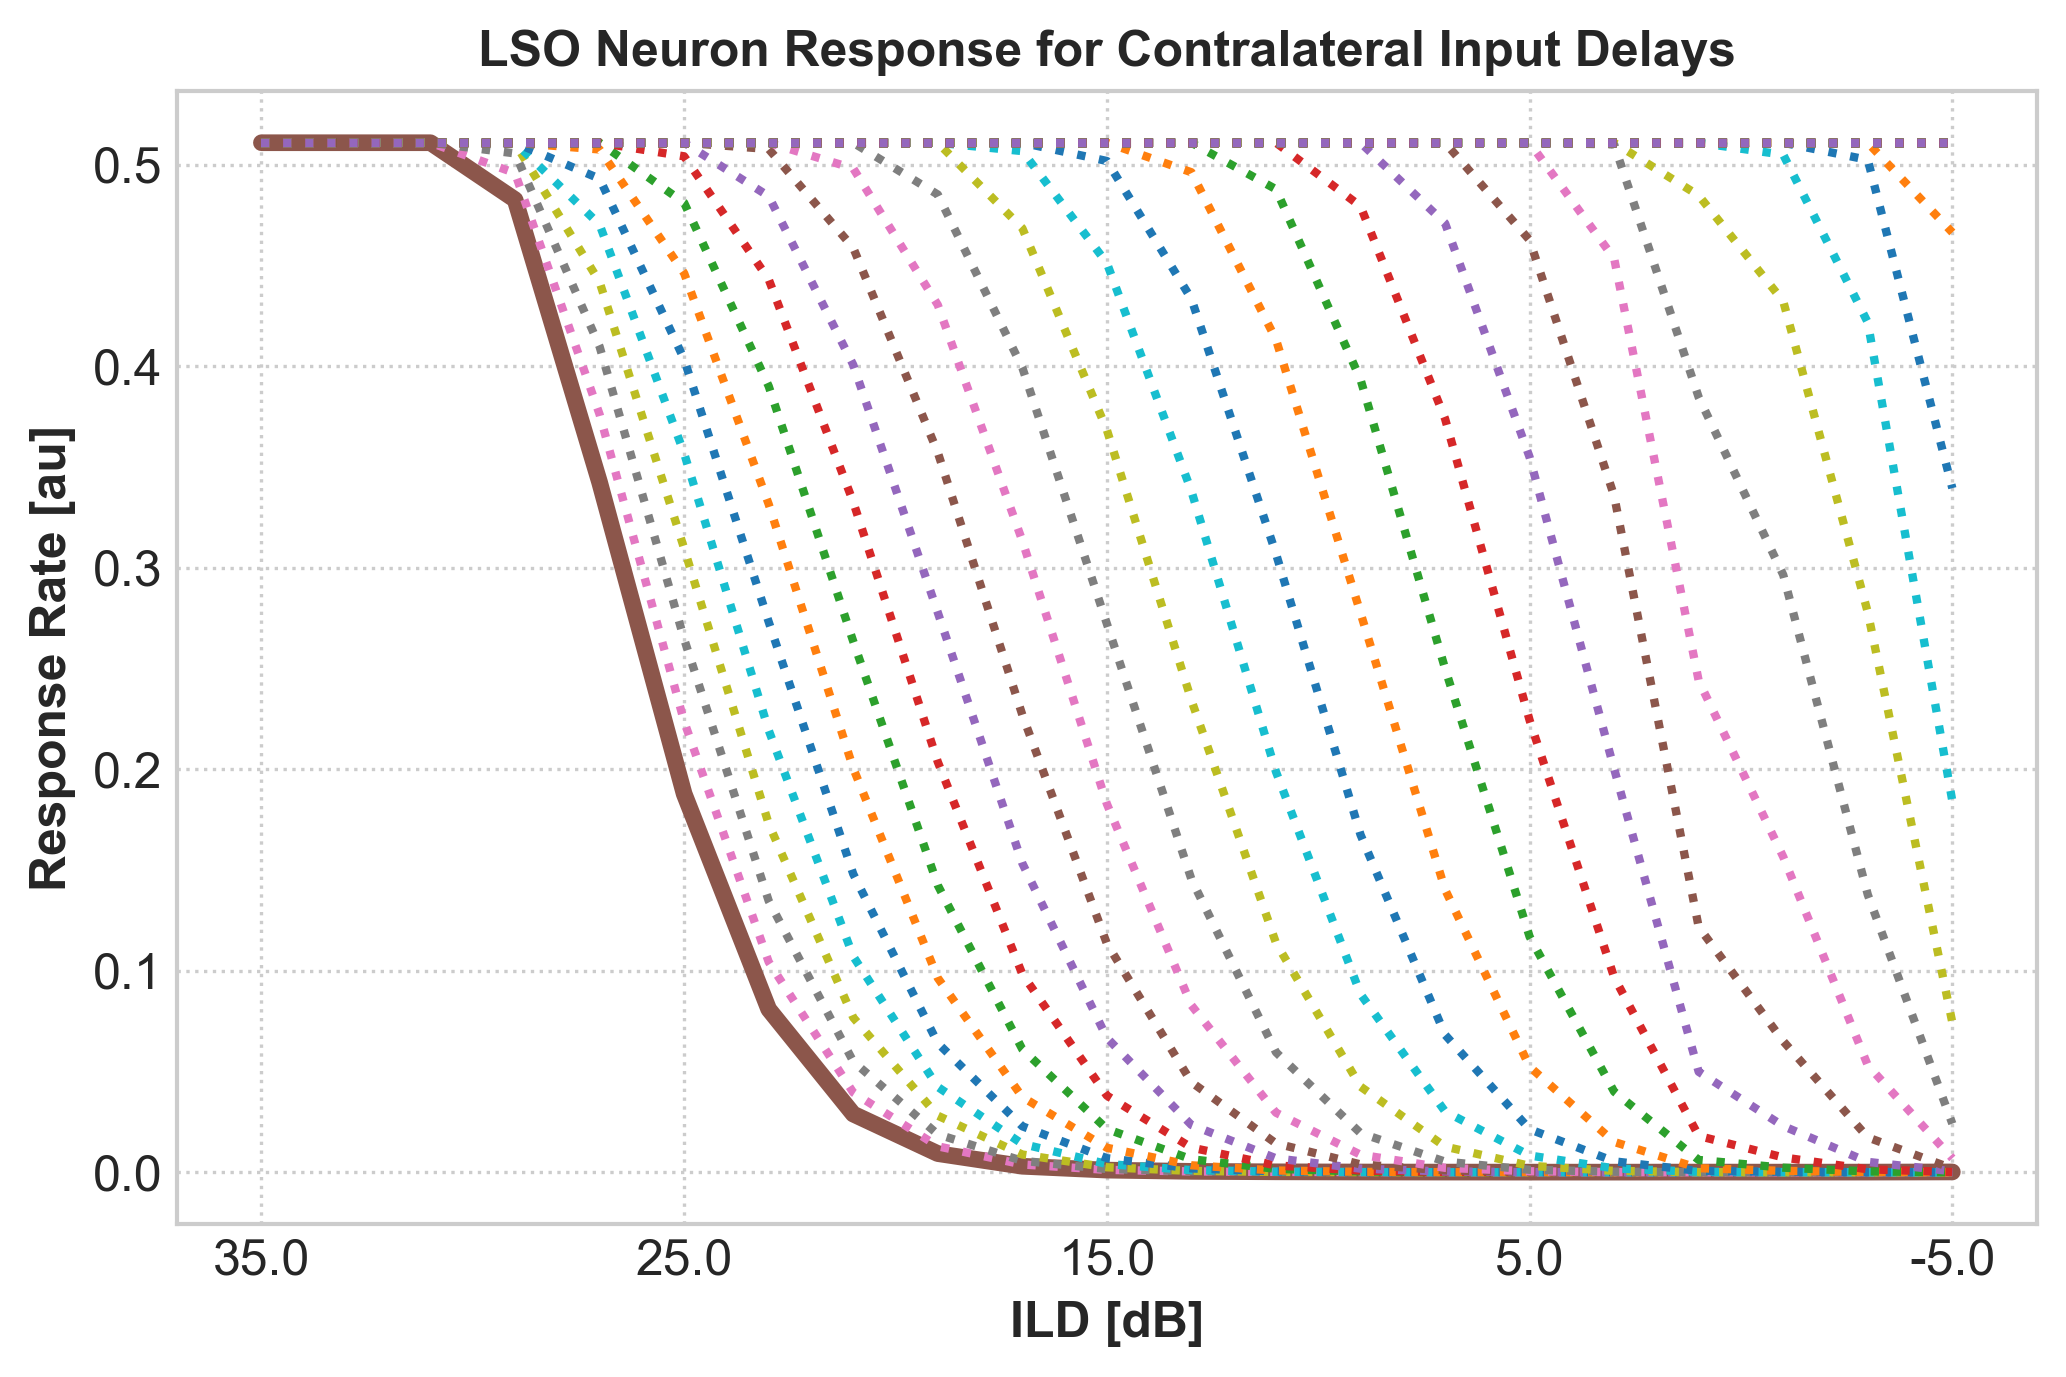

In [235]:
fig = plt.figure()

r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
ax1 = fig.add_subplot(111)
# for i in range(28,r.shape[0]-10,2):
for i in range(0,r.shape[0],1):
    
    if gbc_offsets[i] > 0:
        line_style = ''
        line_width = 2
    elif gbc_offsets[i] == 0:
        line_style = '-'
        line_width = 4
        print(i)
    else:
        line_style = ':'
        line_width = 2
    ax1.plot((sbc_input_intensities-gbc_input_intensities),r[i,:,probing_time],linewidth=line_width,linestyle=line_style,label='ITD = {0:.2f}'.format(gbc_offsets[i]*10))
#     ax1.plot((sbc_input_intensities-gbc_input_intensities),np.max(r[i,:,:],axis=1),linewidth=line_width,linestyle=line_style,label='ITD = {0:.2f}'.format(gbc_offsets[i]*10))


diff = sbc_input_intensities-gbc_input_intensities
ax1.set_xticks(diff[::5])
ax1.set_xticklabels(["{0:2.2f}".format(i*100) for i in ax1.get_xticks()])

plt.title('LSO Neuron Response for Contralateral Input Delays')
plt.xlabel('ILD [dB]')
ax1.set_xticklabels(np.round(ax1.get_xticks()*100))
plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
# lgd = plt.legend(loc=(1.04,0))

plt.savefig(figure_name + 'ild.svg', bbox_inches='tight')
plt.savefig(figure_name + 'ild.pdf', bbox_inches='tight')


plt.show()

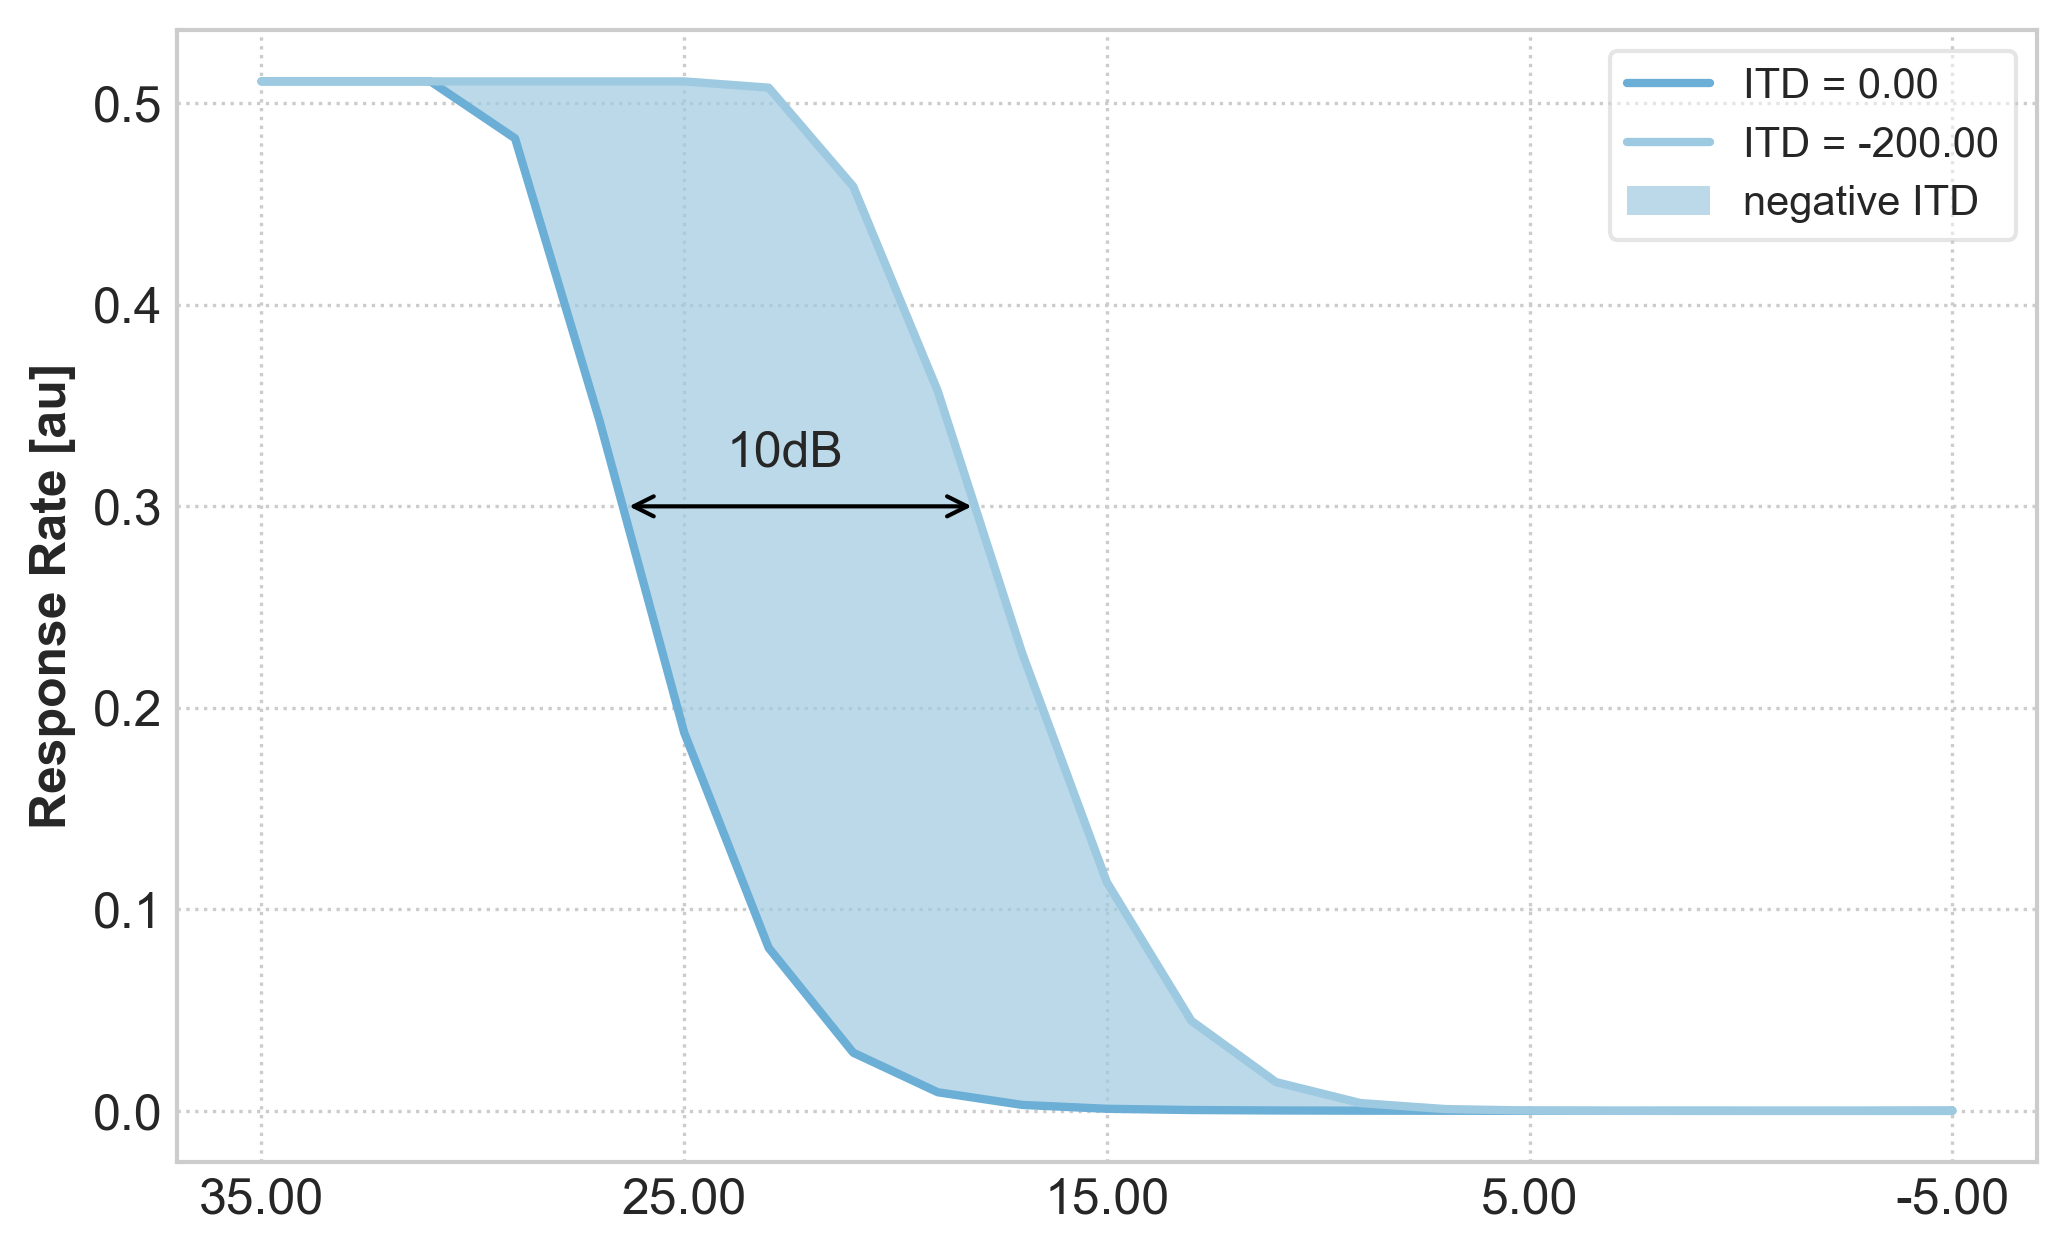

In [255]:
fig = plt.figure()

# probing_time = 1200
r = g_r_out(r_all[:,:,:,sbc_center_frequencyBand])
q = q_all[:,:,:,sbc_center_frequencyBand]
ax1 = fig.add_subplot(111)
diff = sbc_input_intensities-gbc_input_intensities

lower_bound = 50
zero_bound = 55
higher_bound = 65
    
# ax1.plot((sbc_input_intensities-gbc_input_intensities),r[lower_bound,:,probing_time],linestyle='-',color = 'C0',label='ITD = {0:.2f}'.format(gbc_offsets[lower_bound]*10))
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[zero_bound,:,probing_time],linestyle='-',color = '#6baed6',label='ITD = {0:.2f}'.format(gbc_offsets[zero_bound]*10))
ax1.plot((sbc_input_intensities-gbc_input_intensities),r[higher_bound,:,probing_time],linestyle='-',color = '#9ecae1',label='ITD = {0:.2f}'.format(gbc_offsets[higher_bound]*10))

# ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[lower_bound,:,probing_time], r[zero_bound,:,probing_time], facecolor='#6baed6', alpha=0.7,label='positive ITD')
ax1.fill_between((sbc_input_intensities-gbc_input_intensities), r[zero_bound,:,probing_time], r[higher_bound,:,probing_time], facecolor='#9ecae1', alpha=0.7,label='negative ITD')



# x1 = diff[np.argmax(-np.gradient(r[lower_bound,:,probing_time]))]
x2 = diff[np.argmax(-np.gradient(r[zero_bound,:,probing_time]))]
x3 = diff[np.argmax(-np.gradient(r[higher_bound,:,probing_time]))]

ax1.annotate("", xy=(x2-0.005, 0.3), xytext=(x3+0.01, 0.3),arrowprops=dict(arrowstyle="<->",linewidth=1))
ax1.annotate("{0:2.0f}dB".format((x2-x3)*100), xy=(0,0), xytext=(0.24,0.32))

# ax1.annotate("", xy=(x1, 0.5), xytext=(x2, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=1))
# ax1.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=(0,0), xytext=(0.40,0.55))


diff = sbc_input_intensities-gbc_input_intensities
ax1.set_xticks(diff[::5])
ax1.set_xticklabels(["{0:2.2f}".format(i*100) for i in ax1.get_xticks()])


plt.ylabel('Response Rate [au]')
ax1.invert_xaxis()
lgd = plt.legend()

plt.savefig(figure_name + 'ild_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'ild_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'ild_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

In [1]:
import dill
# dill.dump_session('fig_5_1_park_results')
dill.load_session('fig_5_1_park_results')